In [28]:
import pandas as pd
import re

# --- Normalization helper ---
def normalize_series(s):
    """Uppercase, strip, remove all non-alphanumeric characters (spaces, punctuation)."""
    return (
        s.astype(str)
        .str.upper()
        .str.strip()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

# Load dataset
csv_path = "https://raw.githubusercontent.com/ChiriKamau/soma/main/data/Population_scounty_age_gender.csv"
df = pd.read_csv(csv_path)

# Normalize names
df["COUNTY_NORM"] = normalize_series(df["ewcounty"])
df["SUBCOUNTY_NORM"] = normalize_series(df["sub-county"])

# --- Aggregate population per subcounty ---
# Keep only numeric ages or "Total"
df_clean = df[df["Age"].astype(str).str.isdigit() | (df["Age"].str.upper() == "TOTAL")].copy()
df_clean["Total"] = pd.to_numeric(df_clean["Total"], errors="coerce").fillna(0)

# Subcounty population totals
sub_totals = (
    df_clean.groupby(["COUNTY_NORM", "SUBCOUNTY_NORM"], as_index=False)["Total"].sum()
)

# 🔴 Exclude subcounties with total population < 2000
valid_subs = sub_totals[sub_totals["Total"] >= 2000][["COUNTY_NORM", "SUBCOUNTY_NORM"]]

# Keep only valid subcounties in main dataframe
df = df.merge(valid_subs, on=["COUNTY_NORM", "SUBCOUNTY_NORM"], how="inner")

# --- Assign county & subcounty codes ---
county_map = {c: i+1 for i, c in enumerate(sorted(df["COUNTY_NORM"].unique()))}
df["COUNTY_CODE"] = df["COUNTY_NORM"].map(county_map)

def subcounty_codes(x):
    """Assign codes alphabetically within county, reserve 0 for 'ALL'."""
    subs = sorted([sc for sc in x.unique() if sc != "ALL"])
    return {sc: i+1 for i, sc in enumerate(subs)}

sub_map_df = (
    df.groupby("COUNTY_NORM")["SUBCOUNTY_NORM"]
    .apply(lambda x: subcounty_codes(x))
)

def get_sub_code_df(row):
    if row["SUBCOUNTY_NORM"] == "ALL":
        return 0
    try:
        return sub_map_df[row["COUNTY_NORM"]][row["SUBCOUNTY_NORM"]]
    except:
        return None

df["SUBCOUNTY_CODE"] = df.apply(get_sub_code_df, axis=1)

print("✅ CSV processed: counties + subcounties numbered (ALL = 0)")
print(f"Kept {df['SUBCOUNTY_NORM'].nunique()} valid subcounties (pop ≥ 2000)")
df[["ewcounty", "sub-county", "COUNTY_CODE", "SUBCOUNTY_CODE"]].head(20)


✅ CSV processed: counties + subcounties numbered (ALL = 0)
Kept 335 valid subcounties (pop ≥ 2000)


,ewcounty,sub-county,COUNTY_CODE,SUBCOUNTY_CODE
0,BARINGO,ALL,1,0.0
1,BARINGO,ALL,1,0.0
2,BARINGO,ALL,1,0.0
3,BARINGO,ALL,1,0.0
4,BARINGO,ALL,1,0.0
5,BARINGO,ALL,1,0.0
6,BARINGO,ALL,1,0.0
7,BARINGO,ALL,1,0.0
8,BARINGO,ALL,1,0.0
9,BARINGO,ALL,1,0.0


In [61]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import re

def normalize(s):
    return (
        s.astype(str)
        .str.upper()
        .str.strip()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

# --- Load shapefile ---
gdf = gpd.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.0/gpkg/gadm40_KEN.gpkg",
    layer=2
)
gdf["COUNTY_NORM"] = normalize(gdf["NAME_1"])
gdf["SUBCOUNTY_NORM"] = normalize(gdf["NAME_2"])

# County & subcounty codes
county_map = {c: i+1 for i, c in enumerate(sorted(gdf["COUNTY_NORM"].unique()))}
gdf["COUNTY_CODE"] = gdf["COUNTY_NORM"].map(county_map)
sub_map = gdf.groupby("COUNTY_NORM")["SUBCOUNTY_NORM"].apply(
    lambda x: {sc: i+1 for i, sc in enumerate(sorted(x.unique()))}
)
gdf["SUBCOUNTY_CODE"] = gdf.apply(
    lambda r: sub_map[r["COUNTY_NORM"]].get(r["SUBCOUNTY_NORM"]), axis=1
)

# --- Load population data ---
df = pd.read_csv(
    "https://raw.githubusercontent.com/ChiriKamau/soma/main/data/Population_scounty_age_gender.csv"
)
df["COUNTY_NORM"] = normalize(df["ewcounty"])
df["SUBCOUNTY_NORM"] = normalize(df["sub-county"])
df["Age"] = df["Age"].astype(str).str.strip()

# Keep only numeric ages and "TOTAL" (drop ranges like "0-4")
df_clean = df[df["Age"].str.isdigit() | (df["Age"].str.upper() == "TOTAL")].copy()

# Convert population column to numeric
df_clean["Total"] = pd.to_numeric(df_clean["Total"], errors="coerce").fillna(0)

# Assign codes
county_map_df = {c: i+1 for i, c in enumerate(sorted(df_clean["COUNTY_NORM"].unique()))}
df_clean["COUNTY_CODE"] = df_clean["COUNTY_NORM"].map(county_map_df)
sub_map_df = df_clean.groupby("COUNTY_NORM")["SUBCOUNTY_NORM"].apply(
    lambda x: {sc: i+1 for i, sc in enumerate(sorted([sc for sc in x.unique() if sc != "ALL"]))}
)
df_clean["SUBCOUNTY_CODE"] = df_clean.apply(
    lambda r: 0 if r["SUBCOUNTY_NORM"] == "ALL" else sub_map_df[r["COUNTY_NORM"]].get(r["SUBCOUNTY_NORM"]),
    axis=1
)

# --- Aggregation ---
df_sub = df_clean[df_clean["SUBCOUNTY_CODE"] != 0]

# Per-age population (keep for later analysis)
pop_by_age = df_sub.groupby(
    ["COUNTY_CODE", "SUBCOUNTY_CODE", "Age"], as_index=False
)["Total"].sum()

# Aggregate totals per subcounty
pop_totals = (
    pop_by_age.groupby(["COUNTY_CODE", "SUBCOUNTY_CODE"], as_index=False)["Total"]
    .sum()
    .rename(columns={"Total": "SubcountyTotal"})
)

# 🔹 Remove subcounties with total population < 2000
pop_totals = pop_totals[pop_totals["SubcountyTotal"] >= 2000]

print("✅ Processed population totals (filtered <2000)")
print(pop_totals.head())


✅ Processed population totals (filtered <2000)
   COUNTY_CODE  SUBCOUNTY_CODE  SubcountyTotal
0            1             1.0        193865.0
1            1             2.0        209693.0
2            1             3.0        159831.0
3            1             4.0        259034.0
4            1             5.0        181882.0


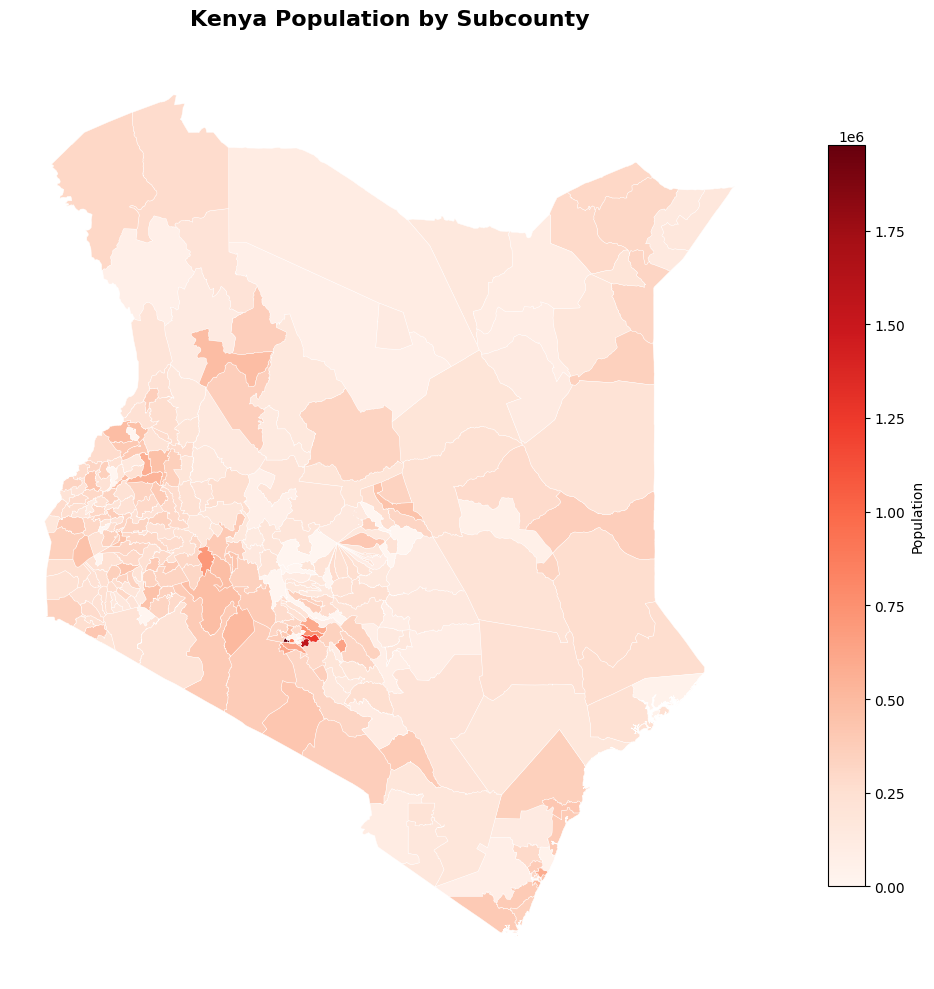

Map created using your coding system
Mapped 282 subcounties with population data
Population range: 0 - 1,977,440

TOP 10 HIGHEST POPULATION SUBCOUNTIES:
 1. Dagoretti South, Nairobi: 1,977,440
 2. Embakasi East, Nairobi: 1,561,172
 3. Kasarani, Nairobi: 1,252,851
 4. Dagoretti North, Nairobi: 868,310
 5. Ruiru, Kiambu: 742,146
 6. Molo, Nakuru: 710,631
 7. Kangundo, Machakos: 644,954
 8. Langata, Nairobi: 617,645
 9. Kajiado North, Kajiado: 613,120
10. Juja, Kiambu: 601,812

TOP 10 LOWEST POPULATION SUBCOUNTIES:
 1. Webute West, Bungoma: 7,242
 2. Lamu East, Lamu: 44,508
 3. Kilifi South, Kilifi: 45,272
 4. Balambala, Garissa: 64,511
 5. Laisamis, Marsabit: 71,418
 6. Laikipia West, Laikipia: 72,352
 7. Loima, Turkana: 73,535
 8. Thika Town, Kiambu: 77,884
 9. Kinango, Kwale: 78,080
10. Kitui Rural, Kitui: 92,240

SUMMARY STATISTICS:
Total subcounties with data: 282
Average population: 296,442
Median population: 268,807


In [62]:
# --- Merge with shapefile ---
gdf_merged = gdf.merge(pop_totals, on=["COUNTY_CODE", "SUBCOUNTY_CODE"], how="left")
gdf_merged["SubcountyTotal"] = gdf_merged["SubcountyTotal"].fillna(0)

# --- Plot map ---
fig, ax = plt.subplots(figsize=(12, 10))
gdf_merged.plot(
    column="SubcountyTotal",
    cmap="Reds",
    ax=ax,
    edgecolor="white",
    linewidth=0.3
)
sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_merged["SubcountyTotal"].min(),
        vmax=gdf_merged["SubcountyTotal"].max()
    )
)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, label="Population")
ax.set_title("Kenya Population by Subcounty", fontsize=16, fontweight="bold", pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()

# --- Reports ---
print("Map created using your coding system")
print(f"Mapped {len(gdf_merged[gdf_merged['SubcountyTotal'] > 0])} subcounties with population data")
print(f"Population range: {int(gdf_merged['SubcountyTotal'].min()):,} - {int(gdf_merged['SubcountyTotal'].max()):,}\n")

populated = gdf_merged[gdf_merged["SubcountyTotal"] > 0]

print("TOP 10 HIGHEST POPULATION SUBCOUNTIES:")
print("="*50)
for i, row in populated.nlargest(10, "SubcountyTotal")[["NAME_2", "NAME_1", "SubcountyTotal"]].reset_index(drop=True).iterrows():
    print(f"{i+1:2d}. {row['NAME_2']}, {row['NAME_1']}: {int(row['SubcountyTotal']):,}")

print("\nTOP 10 LOWEST POPULATION SUBCOUNTIES:")
print("="*50)
for i, row in populated.nsmallest(10, "SubcountyTotal")[["NAME_2", "NAME_1", "SubcountyTotal"]].reset_index(drop=True).iterrows():
    print(f"{i+1:2d}. {row['NAME_2']}, {row['NAME_1']}: {int(row['SubcountyTotal']):,}")

print("\nSUMMARY STATISTICS:")
print(f"Total subcounties with data: {len(populated):,}")
print(f"Average population: {int(populated['SubcountyTotal'].mean()):,}")
print(f"Median population: {int(populated['SubcountyTotal'].median()):,}")
